<a href="https://colab.research.google.com/github/alansartorio/itba-sia/blob/main/EjercicioObligatorio/Ej_SIA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow as tf
from tensorflow import keras
import scipy
from functools import partial
import numpy as np



In [3]:
ξ = np.array([[4.4793, -4.0765, -4.0765], [-4.1793, -4.9218, 1.7664], [-3.9429, -0.7689, 4.8830]], dtype=np.float64)
ζ = np.array([0, 1, 1], dtype=np.float64)

In [4]:
from math import exp

def numpy_F(W, w, wₒ, ξ):
  def g(x):
    return np.exp(x)/(1+np.exp(x))
  
  
  def inner_sum(W, w, wₒ, ξ, j):
    return np.dot(w[j, :], ξ) - wₒ[j]
  
  def outer_sum(W, w, wₒ, ξ):
    return (W[1]*g(inner_sum(W, w, wₒ, ξ, 0)) + W[2]*g(inner_sum(W, w, wₒ, ξ, 1))) - W[0]
  
  def F(W, w, wₒ, ξ):
    return g(outer_sum(W, w, wₒ, ξ))
  
  return F(W, w, wₒ, ξ)
  
def numpy_E(W, w, wₒ):
  def E(W, w, wₒ):
    return np.sum((ζ - numpy_F(W, w, wₒ, ξ)) ** 2)
  
  return E(W, w, wₒ)

@tf.function
def tensor_F(W, w, wₒ, ξ):
  def g(x):
    return tf.math.exp(x)/(1+tf.math.exp(x))
  
  
  def inner_sum(W, w, wₒ, ξ, j):
    return tf.tensordot(w[j, :], ξ, 1) - wₒ[j]
  
  def outer_sum(W, w, wₒ, ξ):
    return (W[1]*g(inner_sum(W, w, wₒ, ξ, 0)) + W[2]*g(inner_sum(W, w, wₒ, ξ, 1))) - W[0]
  
  def F(W, w, wₒ, ξ):
    return g(outer_sum(W, w, wₒ, ξ))
  
  return F(W, w, wₒ, ξ)
  
@tf.function
def tensor_E(W, w, wₒ):
  def E(W, w, wₒ):
    return tf.math.reduce_sum((ζ - tensor_F(W, w, wₒ, ξ)) ** 2)
  
  return E(W, w, wₒ)

def map_inputs(x):
  return x[0:3], np.reshape(x[3:9], (2, 3)), x[9:]

[6.01321930e-01 2.57792570e-01 4.96791919e-02 2.14663952e-01
 1.24046821e-01 9.05301944e-01 7.98870153e-04 7.20107658e-01
 1.94821695e-01 9.82796056e-01 9.62826609e-01]
[0.5333639633290288, 0.06869800508280528, 0.013527826644117637, 0.007420211746281799, 0.003452672697604146, 0.0020801659024328022, 0.0006551625345251133, 0.0002081336558467706, 4.881116333314618e-05, 2.1167263814587816e-05, 4.214035335358107e-06, 2.5279666810891374e-06, 1.0158845623915264e-06, 3.9500815476610436e-07, 2.081739930234323e-08, 1.7406634214327966e-09, 7.94333042593774e-11, 5.534064619643029e-11, 1.8445245402670275e-11, 4.482020213778018e-12, 1.141987250014594e-12]
1.141987250014594e-12


HTML(value='')

HTML(value='')

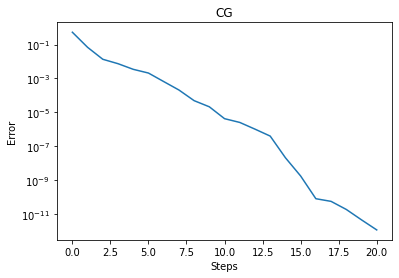

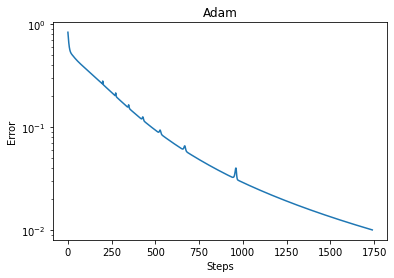

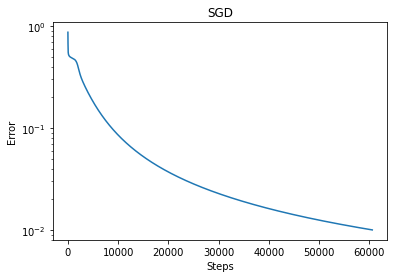

In [46]:
import matplotlib.pyplot as plt
from IPython.display import display
from ipywidgets import IntProgress, HTML, VBox

errors=[]
def callback(values):
  errors.append(numpy_E(*map_inputs(values)))

CG = partial(scipy.optimize.minimize, method='CG', callback=callback, options={"gtol": -1e10, "maxiter":10000})
Adam = keras.optimizers.Adam(0.05, 0.09, 0.999, 1e-8, False)
SGD = keras.optimizers.SGD(0.01, 0.8, False)

starting_values=np.random.rand(11)
print(starting_values)
m = CG(lambda x:numpy_E(*map_inputs(x)), starting_values).x
print(errors)

def plot(title, errors):
  fig, ax = plt.subplots()
  plt.xlabel('Steps')
  plt.ylabel('Error')
  plt.title(title)
  ax.plot(errors)
  ax.set_yscale('log')

W, w, wₒ = map_inputs(m)
print(numpy_E(W, w, wₒ))
#print(tensor_E(W, w, wₒ))
plot('CG', errors)

def test_optimizer(title, method):
  errors = []
  m = tf.Variable(starting_values)

  #previous_vars = None
  #while previous_vars is None or np.sum((previous_vars - m.numpy()) ** 2) > 1e-11:
  #  previous_vars = m.numpy().copy()

  label = HTML()
  display(label)

  #for i in range(1000):
  e = 1000
  while e > 1e-2:
    steps = method.minimize(lambda:tensor_E(*map_inputs(m)), m).numpy()
    W, w, wₒ = map_inputs(m)
    #print(numpy_E(W, w, wₒ), np.sum((previous_vars - m.numpy()) ** 2))
    e = numpy_E(W, w, wₒ)
    label.value = f"{title} ERROR: {e}"
    errors.append(e)
  
  plot(title, errors)

test_optimizer('Adam', Adam)
test_optimizer('SGD', SGD)



Este bloque obtiene el resultado optimo.

In [24]:
starting_values=np.random.rand(11)
CG = partial(scipy.optimize.minimize, method='CG', options={"gtol": -1e10, "maxiter":10000})
m = CG(lambda x:numpy_E(*map_inputs(x)), starting_values).x
W, w, wₒ = map_inputs(m)
print('W', W, sep=' = ')
print('w', w, sep=' = ')
print('wₒ', wₒ, sep=' = ')
print(numpy_E(W, w, wₒ))

W = [13.71872365 17.72500962  9.9022185 ]
w = [[-3.97593577  0.62174503  3.60395426]
 [-2.28924315 -0.07190228  2.49112959]]
wₒ = [-0.15664692 -0.11995347]
2.8811057527734308e-12
